# **CS 181 HW5**
---

## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



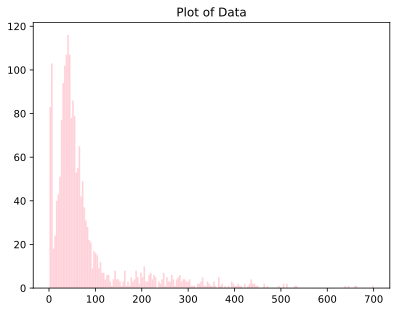

In [14]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = torch.load('data.pt')

alpha = 5.0
plt.hist(x.numpy(), bins=200, color='pink', alpha=0.7)
plt.title("Plot of Data")
plt.show()

In [3]:
# # uncomment to use numpy (optional)
# import numpy as np
# from scipy.stats import gamma
# x = x.numpy()
# theta = theta.numpy()
# betas = betas.numpy()

#### **Todo:** implement the E-step

In [23]:
def e_step(theta, betas):
    alpha = 5.0
    gamma_values = ds.Gamma(alpha, betas)
    #log_prob has the log of the pdf??
    log_q = gamma_values.log_prob(x) + theta.log()
    normalized_q = (log_q - log_q.logsumexp(dim=1, keepdim = True)).exp()
    return normalized_q

#### **Todo:** implement the M-step

In [24]:
def m_step(q):
    alpha = 5.0
    q_sum = q.sum(dim = 0)
    multiplied_sum = (q * x).sum(dim = 0)
    # for the thetas, we just take the mean of the q's
    theta_hat = torch.mean(q, dim=0)
    # for the betas, we do alpha over the expectation of x
    # numerator = alpha * q.sum(dim = 0)
    # denominator = torch.sum(q * x.expand((len(x), K)), dim = 0)
    beta_hats = alpha * q_sum / multiplied_sum
    return theta_hat, beta_hats

#### **Todo:** implement log likelihood

In [30]:
def log_px(x, theta, betas):
    # define the distributions
    categorical = ds.Categorical(theta)
    gamma = ds.Gamma(alpha, betas)
    # very convenient function called MixtureSameDistribution
    model = ds.MixtureSameFamily(categorical, gamma)
    p = model.log_prob(x)
    return p

def log_likelihood(theta, betas):
    return log_px(x, theta, betas).sum()

#### **Todo:** implement EM algorithm

In [31]:
def run_em(theta, betas, iterations=1000):
    # From 9.4.3

    # repeat this for the number of iterations
    for _ in range(iterations):
        # expectation step 
        q = e_step(theta, betas)
        # maximization step
        theta, betas = m_step(q)

    return theta, betas

#### Plot 

In [32]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    prob = log_px(x_test.unsqueeze(-1), theta, betas).exp()
    # prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')
    
    ax.hist(x.T, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')
    
    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

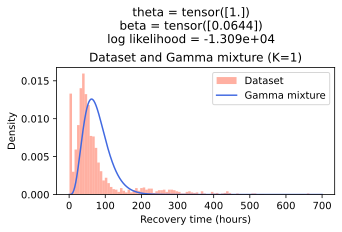

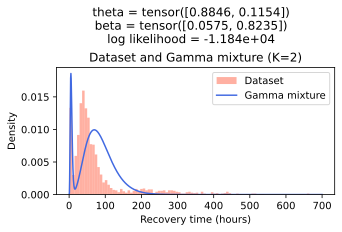

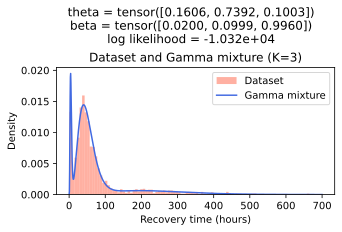

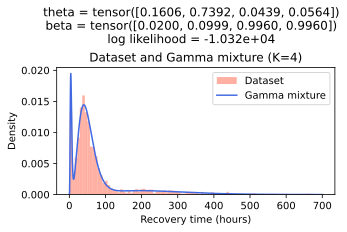

In [33]:
alpha = 5.0
for K in range(1,5):
    theta0 = torch.ones(K) / K
    betas0 = (torch.arange(K) + 1) / K
    # theta0 = np.ones(K) / K               # use this for numpy
    # betas0 = (np.arange(K) + 1) / K
    
    theta, betas = run_em(theta0, betas0)
    
    make_overlay_plot(theta, betas)
    plt.savefig(f'p2_3_{K}mixtures.pdf', bbox_inches='tight')

---
## Problem 3

#### Initialize data:

In [57]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [58]:
def pca(x, n_comps=500):
    # we should first divide the mean centered design matrix by sqrt N
    # axis = 0 means summing over rows whereas axis = 1 is summing over columns
    x_prepped = x - torch.mean(x, axis = 0) 
    # as per the hint, we use .lingalg.svd()
    _, S, Vh = torch.linalg.svd(x_prepped)

    # entries of S are the eigenvalues (they are one-hot encoded)
    # this syntax means that we take all the rows but only the first n_comp columns
    top_singular_values =  S[:n_comps]
    top_eigvals = top_singular_values ** 2

    # principle components are the eigenvectors which are the columns of Vh
    top_pcomps = Vh[:n_comps]
    
    return top_eigvals, top_pcomps

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [59]:
def calc_cfvs(eigvals):
    sum_eigvals = torch.sum(eigvals) 
    #cumsum calculates a cumulative, rolling sum of the values
    cum_frac_vars = torch.cumsum(eigvals/sum_eigvals, dim = 0)
    return cum_frac_vars

#### **Todo:** calculate mean squared L2 norm reconstruction loss

In [60]:
def calc_errs(x, pcomps):
    # subtract mean from each data point
    x_transformed = x - x.mean(dim = 0)
    
    # calculate the reconstruction loss when using the mean image of the data
    # find this in ed
    err_mean = torch.mean(torch.linalg.vector_norm(x_transformed, dim = 1) ** 2)

    # calculate the reconstruction loss when using the first pcomps
    first_ten = pcomps[:10]

    # use equation 7.2
    inner = torch.matmul(x_transformed, first_ten.T)
    combined = torch.matmul(inner, first_ten)
    err_pcomp = (torch.linalg.vector_norm(x_transformed - combined, dim=1) **2).mean()
    return err_mean, err_pcomp

#### Plot and print errors:

In [61]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('p3_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('p3_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('p3_pcomps.pdf')

Reconstruction error (using mean): 3.436023e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


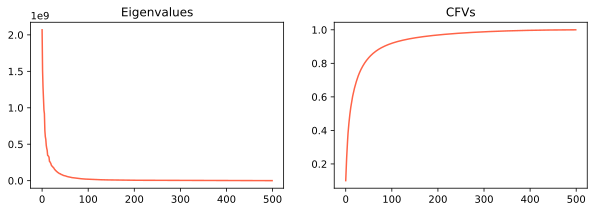

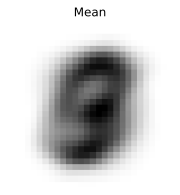

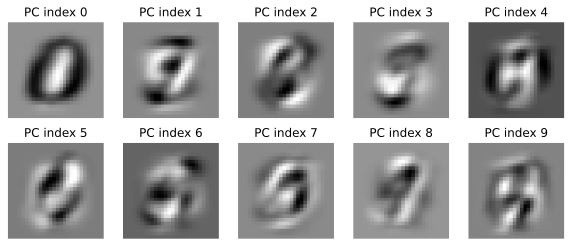

In [62]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean:3e}')
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)


In [5]:
!pip install "pillow<7"

  Using cached Pillow-6.2.2.tar.gz (37.8 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-6.2.2-cp311-cp311-macosx_11_0_arm64.whl size=490371 sha256=2a9e9b79ab19b153617494de051cc887f2165d9b24240191aae55f3d11e492ef
  Stored in directory: /Users/rheaacharya/Library/Caches/pip/wheels/ea/d4/bc/90c63c126a7ecb0307a5832de074f3d57a7f73c519144bdd13
Successfully built pillow
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires pillow<11,>=7.1.0, but you have pillow 6.2.2 which is incompatible.
bokeh 3.3.4 requires pillow>=7.1.0, but you have pillow 6.2.2 which is incompatible.
imageio 2.33.1 requires pillow>=8.3.2, but you have pillow 6.2.2 which is incompati